# Use PCA analysis on tile embeddings

In this notebook you will work with 1000 embedding vectors (with length `100`) produced for a *study* dataset of 1000 tiles. The aim is to answer questions like:

1. Are vectors with 100 elements really needed?

   Using PCA analysis you can look at how many principle components are actually needed to explain say 90% of the   variability. This gives an indication of how many of the embedding vectors are independent. How much is needed for 95% variance?
   
   
2. What features has the neural network picked up in the image?

   Taking individual principle components resulting from the PCA analysis look at what are characteristic properties of tiles in the extremes of each dimension.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import convml_tt

xr.__version__, convml_tt.__version__

('0.15.0', '0.5.0')

In [2]:
tileset_path = Path('../Nx256_s200000.0_N500study_pretrained')

In [3]:
da_emb = xr.open_dataarray(tileset_path/'fixednorm-stage-2.emb.nc')
da_emb.attrs['source_path'] = tileset_path/'study'
# the values are quite small, so let's scale them a bit
# (could instead retrain the model with a loss function that encourages larger values)
da_emb.values = 1.0e4 * da_emb.values
da_emb

<xarray.DataArray (tile_id: 1000, emb_dim: 100)>
array([[ 4.439113e-01, -8.988900e-03,  1.845036e-02, -6.016446e-02, ..., -5.035645e-01,  3.415524e-02, -1.882763e-01,
         3.102875e-01],
       [ 3.746718e-01, -3.905472e-02, -1.944061e-01, -3.712340e-01, ...,  2.646773e-01,  4.308116e-01, -4.589656e-01,
        -1.901568e-02],
       [ 2.817766e-01, -7.063743e-02,  2.045486e-01, -7.083338e-01, ...,  1.590397e-02, -3.190878e-01,  3.008851e-01,
         3.694958e-01],
       [-1.683713e-01,  1.758206e-02, -1.116556e-01,  1.495027e-03, ..., -8.979005e-02, -1.175369e-02, -1.817017e-01,
         2.149013e-01],
       ...,
       [ 5.112088e-04, -6.799819e-02,  1.441675e-01, -3.055122e-01, ...,  3.676909e-02, -5.180820e-02,  5.576241e-01,
         2.163367e-01],
       [-2.969494e-01, -2.210941e-01, -1.465371e-01,  2.636585e-01, ...,  2.662880e-02,  6.221555e-02, -1.242121e-01,
        -1.289532e-01],
       [-2.552627e-01, -1.335888e-01, -1.621911e-01,  3.476777e-01, ...,  3.210507e-01,  1.623332e-01,  9.913253e-02,
        -1.937438e-01],
       [-4.033427e-02, -8.829302e-02,  2.456995e-02, -3.113366e-02, ...,  4.204030e-02,  1.894077e-02, -1.943776e-01,
         1.783152e-01]], dtype=float32)
Coordinates:
  * tile_id  (tile_id) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * emb_dim  (emb_dim) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Attributes:
    source_path:  ../Nx256_s200000.0_N500study_pretrained/study
    tile_used:    anchor

In [4]:
from sklearn.decomposition import PCA

In [5]:
# run PCA analysis with enough components to explains %50 of variance
pca = PCA(n_components=0.50)

# create a numpy array with pca fit
arr_pca = pca.fit_transform(da_emb)

# create an xarray.DataArray to make this array easier to work with
da_pca = xr.DataArray(
    arr_pca,
    dims=('tile_id', 'pca_dim'),
    coords=dict(tile_id=da_emb.tile_id)
)
da_pca.coords['pca_dim'] = np.arange(len(da_pca.pca_dim))
da_pca

<xarray.DataArray (tile_id: 1000, pca_dim: 2)>
array([[ 3.399276e-01, -6.217833e-01],
       [ 1.183764e-01, -1.258273e+00],
       [ 1.391517e+00,  2.436258e+00],
       [ 6.997600e-01, -5.728774e-01],
       ...,
       [ 6.275170e-01,  1.452555e+00],
       [-8.986061e-01,  2.835581e-01],
       [-1.553944e+00,  3.323046e-01],
       [ 1.519980e-03, -2.180406e-01]], dtype=float32)
Coordinates:
  * tile_id  (tile_id) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * pca_dim  (pca_dim) int64 0 1

In [6]:
# how much variance is explained by the principle components identified?
pca.explained_variance_ratio_

array([0.29706 , 0.270723], dtype=float32)

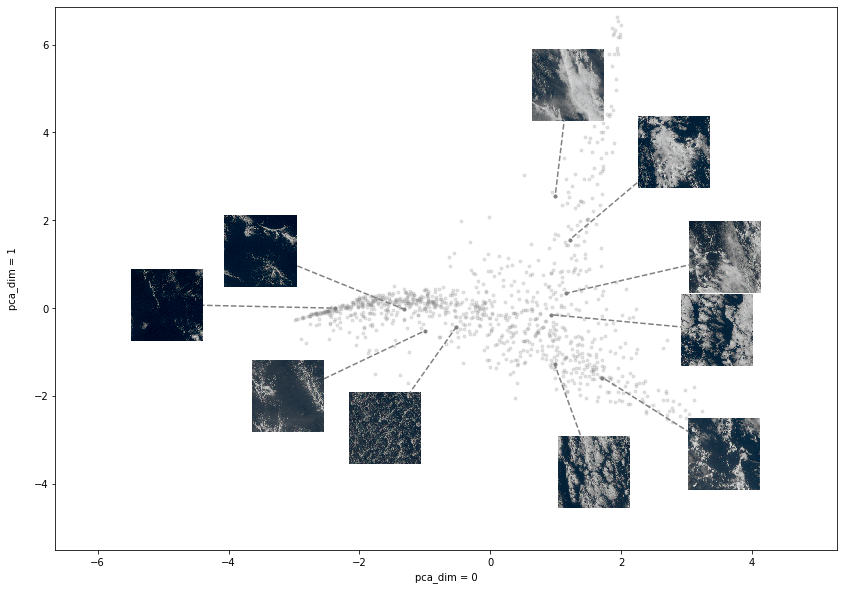

In [7]:
# plot the first two PCA dimensions against each other, annotated with 10 random tiles
da_pca.attrs['source_path'] = da_emb.source_path  # needed so `scatter_annotated` knows where to load tile images from

fig, ax = plt.subplots(figsize=(14, 10))
x = da_pca.sel(pca_dim=0)
y = da_pca.sel(pca_dim=1)
_ = convml_tt.interpretation.plots.scatter_annotated(x, y, points=10, ax=ax)

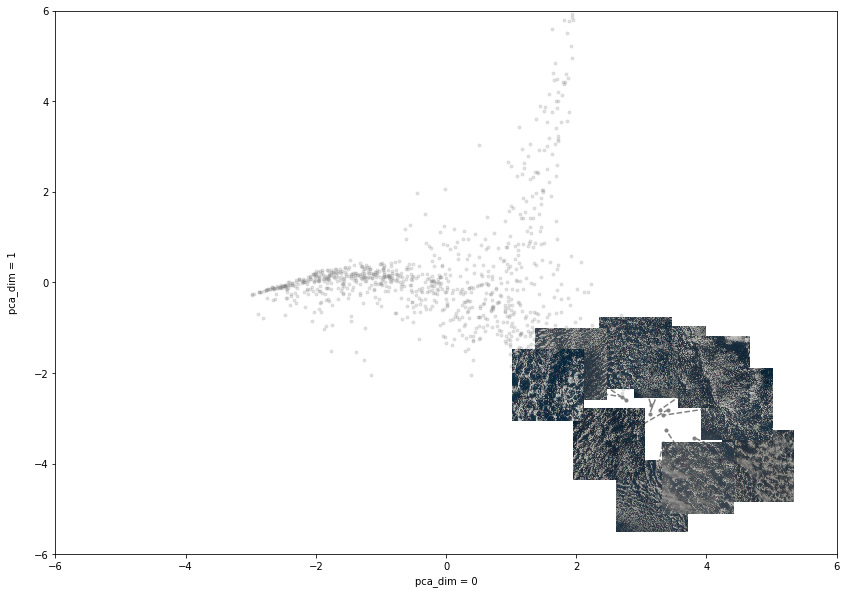

In [8]:
# plot the first two PCA dimensions against each other, annotated with 
# 10 tiles with smallest values for the second component
da_pca.attrs['source_path'] = da_emb.source_path  # needed so `scatter_annotated` knows where to load tile images from

fig, ax = plt.subplots(figsize=(14, 10))
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)

x = da_pca.sel(pca_dim=0)
y = da_pca.sel(pca_dim=1)

da_sorted = da_pca.sortby(da_pca.sel(pca_dim=1))
points = da_sorted.tile_id.values[:10]

_ = convml_tt.interpretation.plots.scatter_annotated(x, y, points=points, ax=ax, annotation_dist=2.0)

### Questions to look at

1. How many components are needed to retain 50%, 90%, 95%, etc of the variance? How many components should be enough when training the neural network?

2. What do the principle components describe? Is it possible to give a physical intepretation about what each principle components measures about the cloud organisation?

If you have more time you could investigate [alternative dimensionality reduction methods](https://scikit-learn.org/stable/modules/unsupervised_reduction.html) in scikit-learn. How do other models differ to PCA and how would that affect your conclusions above?